# Homework 8

---

## Q1: Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm 
import pandas as pd
import arviz as az
import os

In [1]:
%%capture
!pip install kagglehub

import kagglehub

path1 = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

In [4]:
# print(os.listdir(path))

df_q1 = pd.read_csv(os.path.join(path1, 'diabetes_binary_health_indicators_BRFSS2015.csv'))

print(df_q1.shape)
df_q1.head()

(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
predictors = ['BMI', 'Age', 'Sex', 'Education', 'Income']
outcome = 'Diabetes_binary'

X = df_q1[predictors].values
y_binary = df_q1[outcome].astype(int).values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_stdzd = (X - X_mean) / X_std

np.random.seed(30)
n = 300
indices = np.random.choice(len(X_stdzd), size=n, replace=False)
X_sample = X_stdzd[indices]
y_sample = y_binary[indices]

print(X_sample.shape, y_sample.shape)

(300, 5) (300,)


In [9]:
with pm.Model() as logistic:
    
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X_sample.shape[1]) 
    mu = pm.math.dot(X_sample, betas)
    
    # bernoulli likelihood with logit link
    y = pm.Bernoulli('y', p=pm.math.sigmoid(mu), observed=y_sample)
    
    idata = pm.sample(draws=10000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.


In [13]:
az.summary(idata, var_names=['betas'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.33766,0.07322,0.19986,0.47425,0.00034,0.00024,46737.44041,33482.41469,1.00004
betas[1],0.27222,0.06714,0.14525,0.39756,0.00029,0.00021,55034.48136,33063.08873,1.00025
betas[2],0.02095,0.06547,-0.09990,0.14523,0.00029,0.00029,50792.90086,32695.75554,1.00004
betas[3],0.02547,0.07006,-0.10730,0.15647,0.00037,0.00030,36450.01406,33219.17411,1.00004
betas[4],-0.24967,0.07509,-0.38852,-0.10698,0.00037,0.00027,41030.56702,34727.87143,1.00021


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

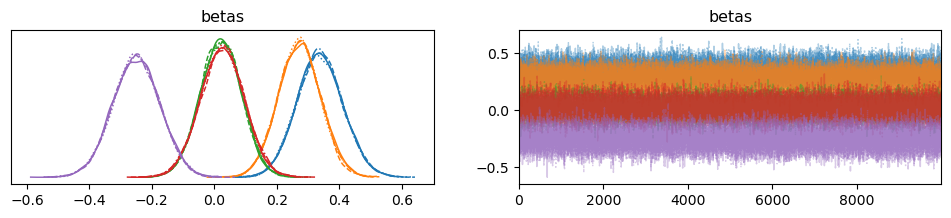

In [14]:
az.plot_trace(idata, var_names=['betas'])

### Posterior Inference and MCMC Diagnostics


The estimated regression coefficients (`betas`) capture the effect of each predictor on the probability of diabetes (`Diabetes_binary`), on the log-odds scale. 

- Beta[0] and beta[1], which correspond to BMI and Age, have positive posterior means with 96% HDIs that do not include zero. This suggests that higher BMI and older age are associated with an increased probability of diabetes.
- Beta[4], which corresponds to Income, has a negative posterior mean of about -0.25, with a HDI that also does not include zero. This indicates that higher income is associated with a lower probability of diabetes.
- Beta[2] and beta[3], which correspond to Sex and Education, have posterior means close to zero and HDIs that include zero. This suggests weak or not significant association with diabetes in this dataset.


The R-hat values for all betas are very close to 1.00, indicating that the chains have converged and mixed well. The effective sample sizes are very large, with bulk ESS and tail ESS over 30,000 for all parameters. This means that the posterior estimates are based on a large number of effectively independent samples and are very stable. 

The MC standard errors (MCSE) for both the mean and standard deviation of each beta are extremely small compared to the posterior standard deviations. This indicates that the uncertainty due to finite sampling is negligible. The trace plots show well-mixed chains without divergences or stuck chains, and the posterior density plots are smooth and unimodal.

The Bayesian logistic regression model has converged well, and the posterior results are stable and reliable. BMI and Age are important predictors of diabetes risk, with positive associations. Income is also an important predictor, showing a negative association. Sex and Education do not show strong effects on diabetes risk on this dataset.


&nbsp;

## Q2: Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [17]:
%%capture
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo 
  
energy_efficiency = fetch_ucirepo(id=242) 
  
X_raw = energy_efficiency.data.features.values
y = energy_efficiency.data.targets.values

# print(y)

In [19]:
np.random.seed(30)
sample_idx = np.random.choice(len(X_raw), 100, replace=False)
X_raw = X_raw[sample_idx]
y_q2 = y[sample_idx]

X_mean = np.mean(X_raw)  
X_std = np.std(X_raw)
X_q2 = (X_raw - X_mean) / X_std

n, p = X_q2.shape
m = y_q2.shape[1]

In [20]:
with pm.Model() as multivariate_model:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_q2@betas, chol=L,  #cov=Sigma
                    observed=y_q2)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-1.159,0.969,-2.955,0.668,0.015,0.012,4116.0,3130.0,1.0
"betas[0, 1]",-2.107,0.950,-3.840,-0.258,0.015,0.011,3788.0,2992.0,1.0
"betas[1, 0]",4.556,0.625,3.429,5.743,0.012,0.008,2757.0,2893.0,1.0
"betas[1, 1]",4.594,0.614,3.463,5.725,0.012,0.009,2625.0,2747.0,1.0
"betas[2, 0]",2.633,0.898,0.991,4.354,0.016,0.011,3305.0,3142.0,1.0
"betas[2, 1]",1.878,0.877,0.278,3.536,0.015,0.011,3217.0,3059.0,1.0
"betas[3, 0]",-0.164,0.947,-1.857,1.701,0.014,0.014,4514.0,3097.0,1.0
"betas[3, 1]",-0.803,0.984,-2.676,1.064,0.014,0.013,4715.0,3144.0,1.0
"betas[4, 0]",-1.102,0.972,-2.877,0.713,0.015,0.012,4378.0,3269.0,1.0
"betas[4, 1]",-2.011,0.964,-3.782,-0.161,0.015,0.011,3911.0,2979.0,1.0


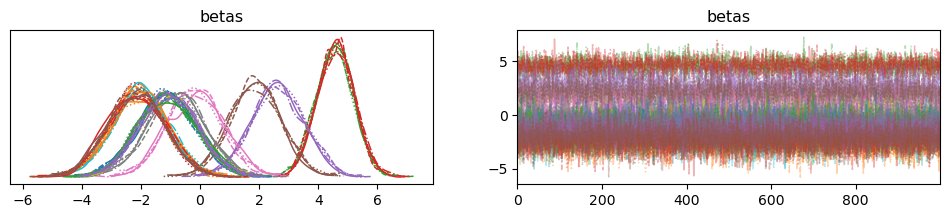

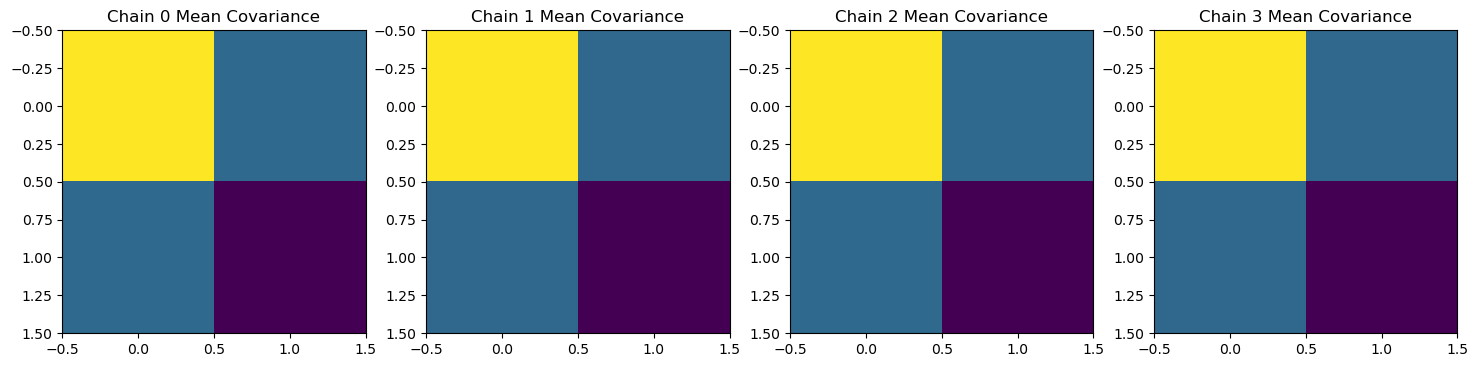

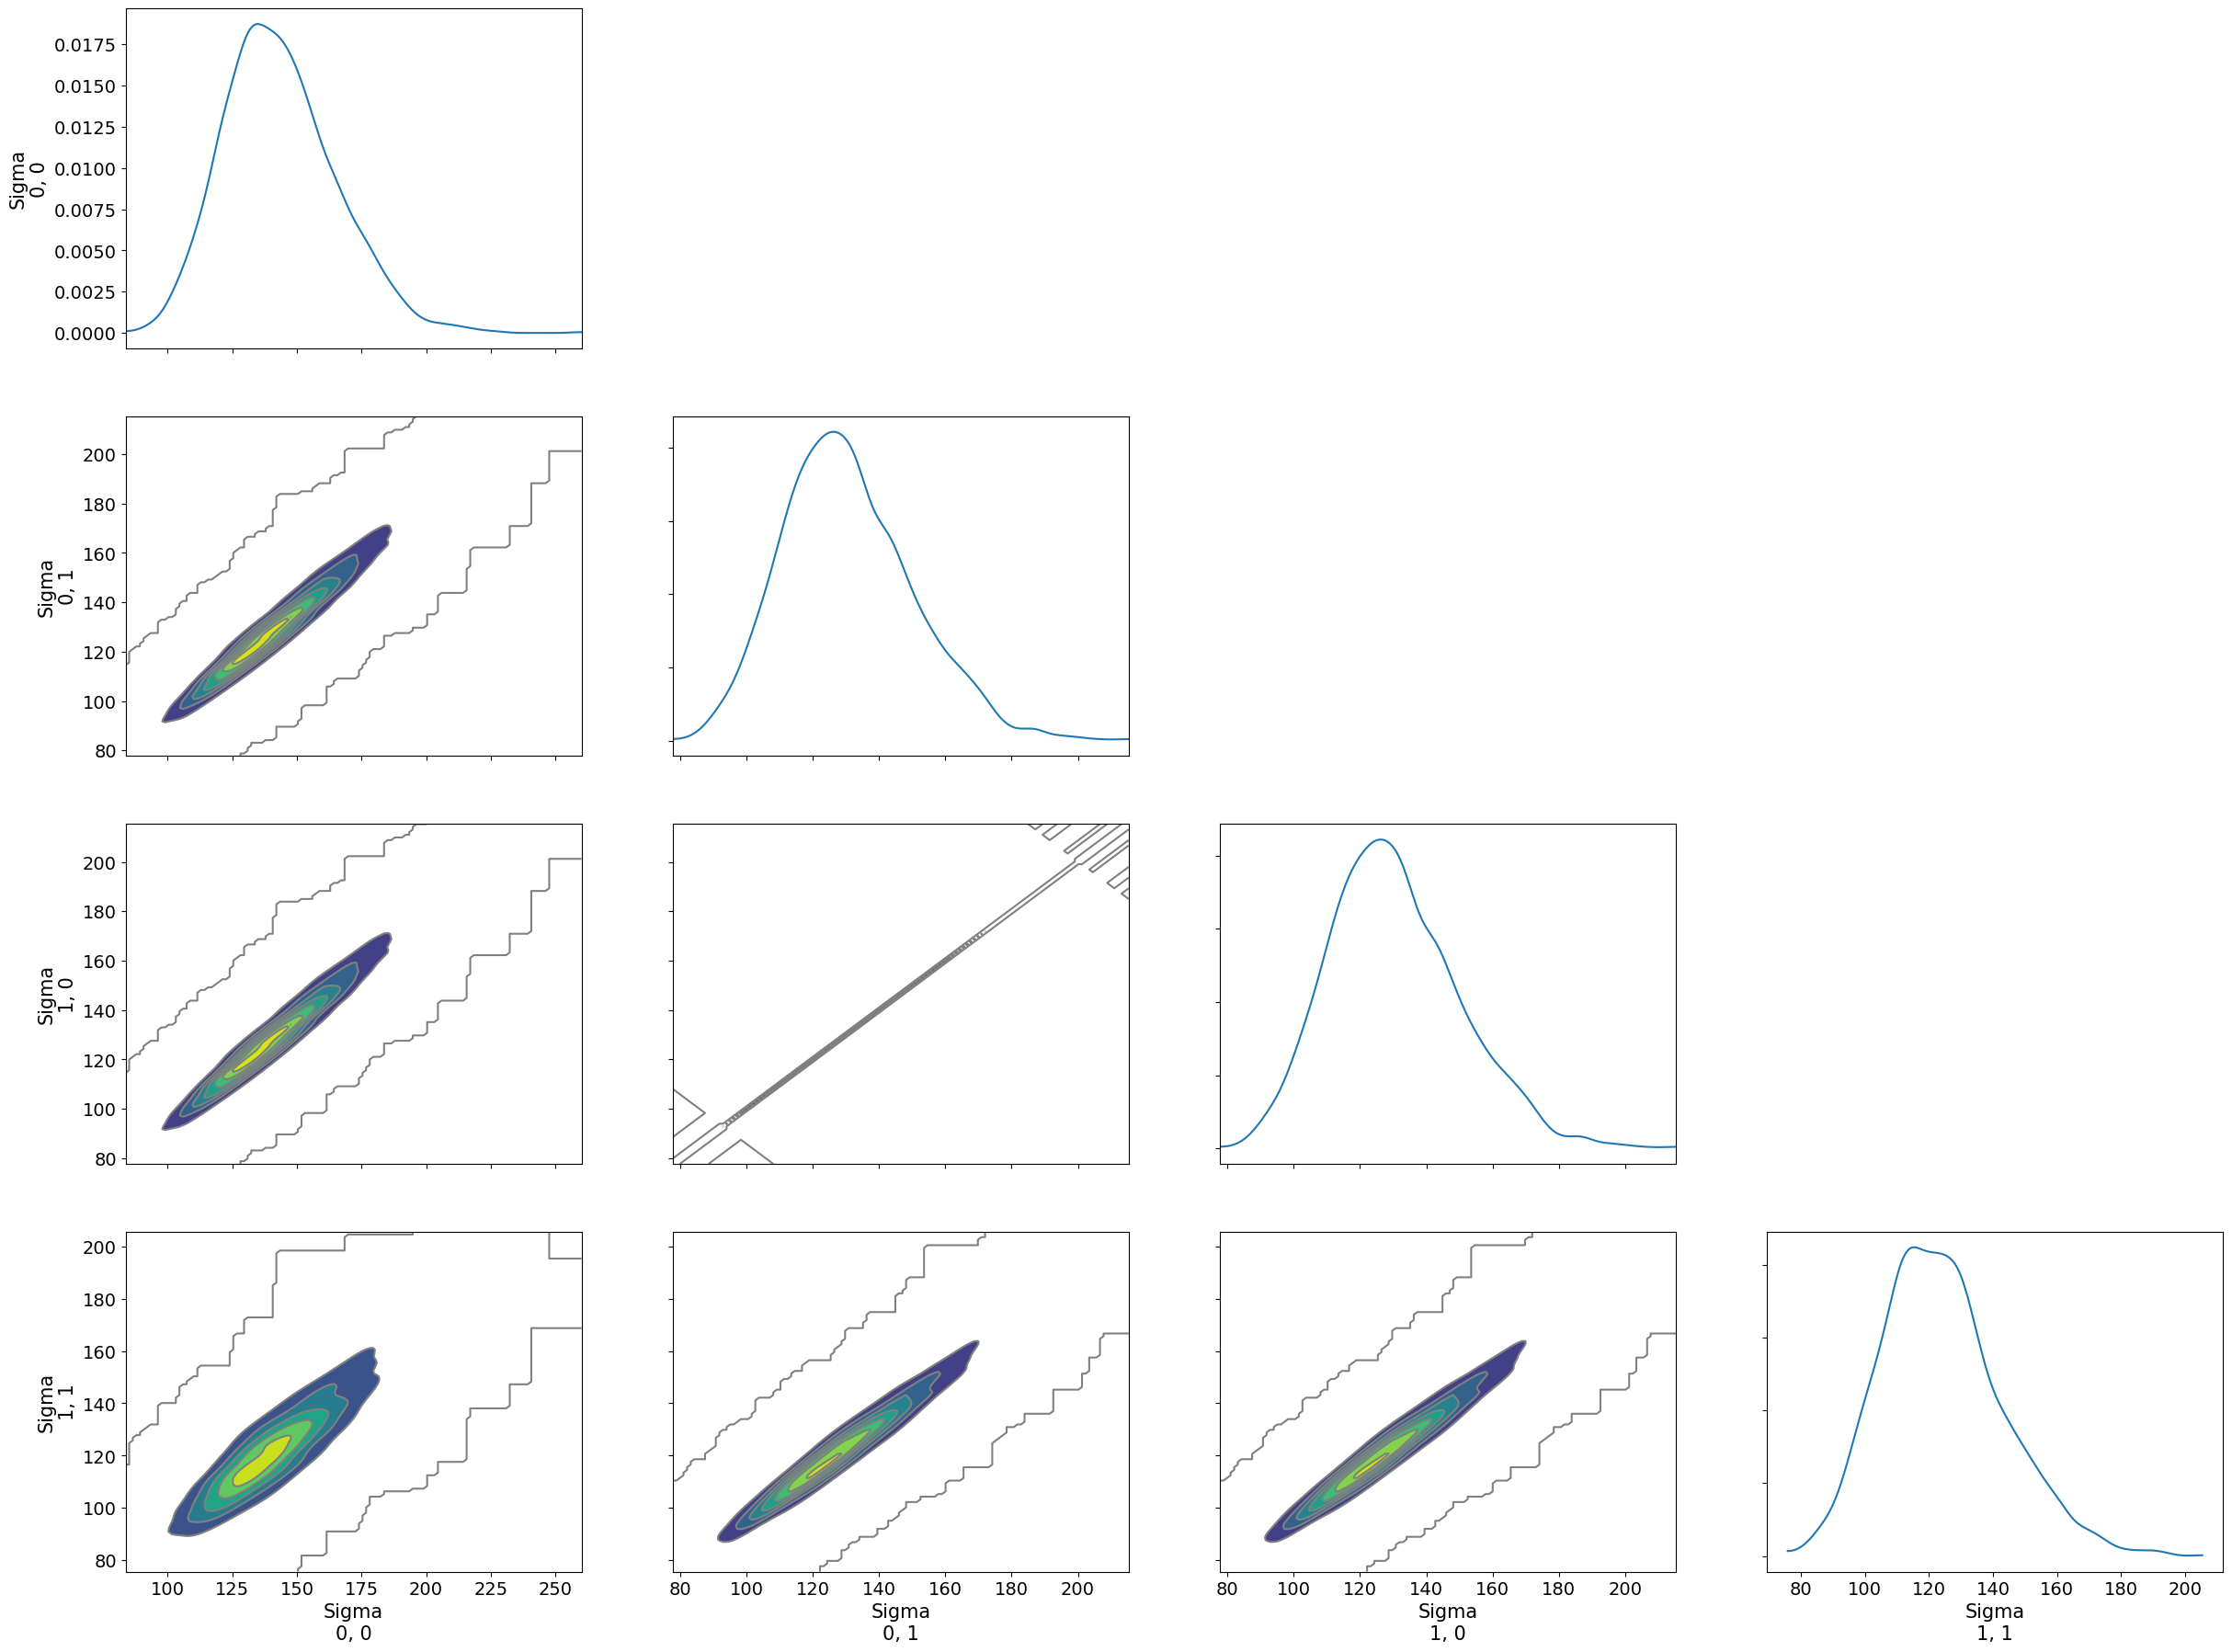

In [21]:
az.plot_trace(idata, var_names='betas')

# covariance matrix visualization
fig,ax = plt.subplots(1,4,figsize=(18,4))
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(f'Chain {chain} Mean Covariance')

# pairplot for covariance parameters
az.plot_pair(idata, var_names=['Sigma'], 
            coords={'Sigma_dim_0': [0,1], 'Sigma_dim_1': [0,1]},
            kind='kde', marginals=True)

az.summary(idata, var_names=['betas', 'Sigma'])

Different values of n, m, and p were explored to assess model performance. Specifically:

- **n** : tested 100, 300, 500  
- **m** : fixed at 2  
- **p** : 5, 8


Models with n = 100, 300, 500 all ran not too slow and showed good convergence. Increasing n led to slightly narrower posterior intervals but longer sampling time. n = 100 was sufficient for stable estimates and fast sampling.

So We used n = 100, m = 2, p = 8 as a reasonably small sample that balances model stability and efficiency.



### Posterior Inference on Betas

The estimated betas represent the effect of each predictor on two continuous outcomes modeled jointly.

From the posterior summary:
- Several betas have HDIs that do not include zero, indicating strong associations between predictors and outcomes.
- For instance, betas[1, 0] and betas[1, 1] show large positive effects (posterior means around 4.56 and 4.59), with narrow credible intervals, suggesting that the corresponding predictor has a significant and strong effect on both outcomes.
- Some betas, such as betas[3, 0] and betas[3, 1], have means near zero and HDIs that include zero, indicating weak or no evidence of association for those predictors.

### Posterior Inference on Sigma

The covariance matrix `Sigma` captures the residual dependency between the two outcomes after adjusting for predictors:
- The diagonal elements (variances) of Sigma are large (posterior means around 130–145), showing substantial residual variability in both outcomes.
- The off-diagonal elements (covariances) show strong and positive posterior means, indicating that the two outcomes remain positively correlated even after accounting for predictors.

---

### MCMC Diagnostics

R-hat values for all parameters are very close to 1.0, indicating excellent convergence.
Effective sample sizes are in the thousands for both bulk and tail, showing a large number of effectively independent samples.
MCSE for both mean and standard deviation are very small relative to the posterior SD, confirming stable and reliable posterior estimates.
Trace plots for betas show well-mixed chains with no divergences or signs of poor mixing.
Posterior density plots for betas are smooth and unimodal, consistent across chains.

Covariance matrix heatmaps across the four MCMC chains are consistent, demonstrating stable estimation of the covariance structure. Posterior pair plots for Sigma components further confirm that the covariance parameters are well-identified and show strong positive relationships between the outcomes.


&nbsp;

### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

## Q3: Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [20]:
%%capture
!pip install kagglehub

import kagglehub

path3 = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

In [24]:
# print(os.listdir(path))

df = pd.read_csv(os.path.join(path3, 'diabetes_binary_health_indicators_BRFSS2015.csv'))

print(df.shape)
df.head()


(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [128]:
print(df.columns.tolist())


['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [29]:
outcome_columns = ['Diabetes_binary', 'HighBP', 'HighChol', 'HeartDiseaseorAttack']
predictor_columns = ['BMI', 'Age', 'Sex', 'Education', 'Income']

y_og = df[outcome_columns].astype(int).values
X_og = df[predictor_columns].values

In [121]:
np.random.seed(30)
n = 300
indices = np.random.choice(len(df), size=n, replace=False)
X_unnormalized = X_og[indices]
y_q3 = y_og[indices]

X_mean = X_unnormalized.mean(axis=0)
X_std = X_unnormalized.std(axis=0)
X_q3 = (X_unnormalized - X_mean) / X_std

print(X_q3.shape)
print(y_q3.shape)


n, p = X_q3.shape
_, m = y_q3.shape


(300, 5)
(300, 4)


In [123]:
with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=8, 
                                sd_dist=pm.Exponential.dist(8, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_q3@betas, chol=L, shape=(n, m)) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_q3)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata = pm.sample(draws=1500, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 200 tune and 1_500 draw iterations (800 + 6_000 draws total) took 839 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.430,0.166,0.126,0.752,0.004,0.003,2335.0,2189.0,1.00
"betas[0, 1]",0.309,0.109,0.102,0.508,0.004,0.003,676.0,1208.0,1.00
"betas[0, 2]",0.300,0.100,0.111,0.485,0.003,0.002,1176.0,1662.0,1.00
"betas[0, 3]",0.101,0.161,-0.197,0.402,0.002,0.002,4387.0,3565.0,1.00
"betas[1, 0]",0.452,0.179,0.122,0.793,0.004,0.003,2444.0,2787.0,1.00
"betas[1, 1]",0.599,0.134,0.358,0.848,0.009,0.006,244.0,645.0,1.02
"betas[1, 2]",0.659,0.126,0.443,0.910,0.008,0.006,252.0,803.0,1.01
"betas[1, 3]",0.412,0.180,0.091,0.762,0.004,0.003,1730.0,2677.0,1.00
"betas[2, 0]",0.068,0.163,-0.245,0.372,0.003,0.002,3600.0,3593.0,1.00
"betas[2, 1]",0.201,0.104,0.003,0.389,0.003,0.002,1158.0,1294.0,1.00


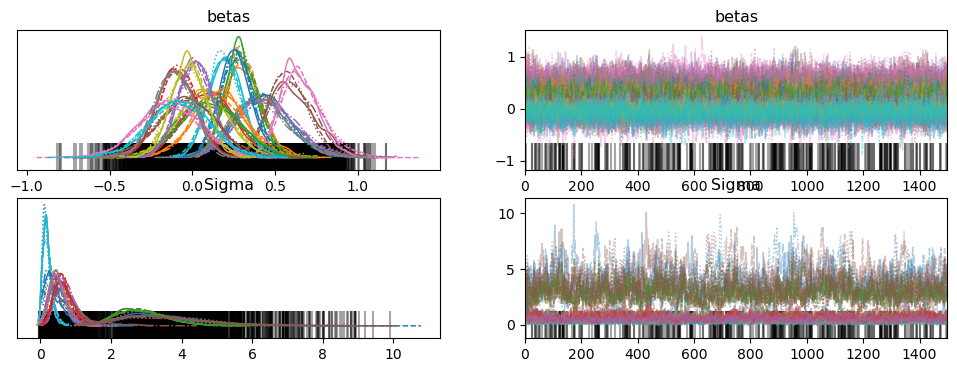

In [124]:
az.plot_trace(idata, var_names=['betas', 'Sigma']) #divergences=None

az.summary(idata, var_names=['betas', 'Sigma']) 

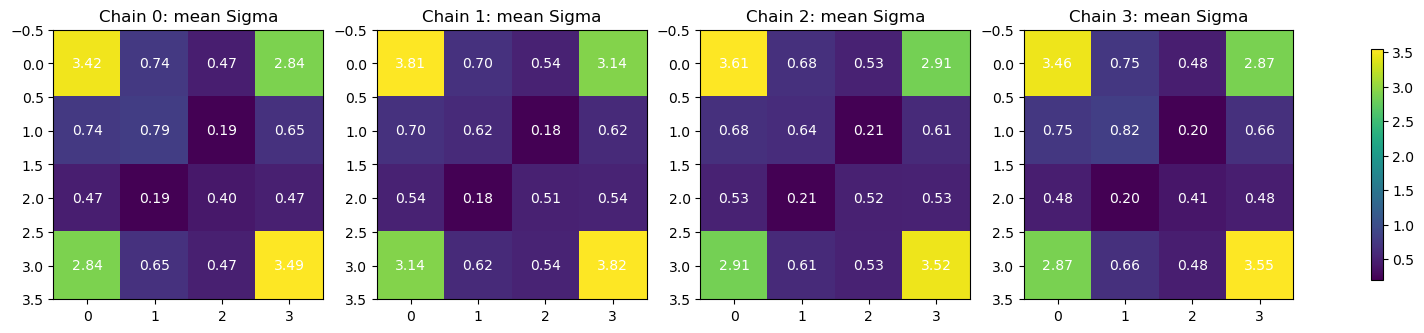

In [125]:
num_chains = 4
fig, axes = plt.subplots(1, num_chains, figsize=(5 * num_chains, 5))

for chain in range(num_chains):
    mean_sigma_chain = idata.posterior['Sigma'].sel(chain=chain).mean(dim='draw').values
    ax = axes[chain]
    im = ax.imshow(mean_sigma_chain)
    ax.set_title(f"Chain {chain}: mean Sigma")
    for i in range(m):
        for j in range(m):
            ax.text(j, i, f"{mean_sigma_chain[i, j]:.2f}", ha='center', va='center', color='w')
plt.colorbar(im, ax=axes.tolist(), shrink=0.6)
plt.show()


We conducted downsampling by varying n. Values of $n = 100, 300, 500, 1000$ are tested, while keeping the number of outcomes $m = 4$ and predictors $p$ = 5 fixed. For smaller samples, the model ran relatively quickly but had greater uncertainty in parameter estimates and chain mixing behaviour. When $n = 1000$, the model took too long to sample. So we selected $n$ = 300 as a reasonable dataset size for the final inference, ensuring reliable estimation and efficient computation.


#### **Posterior inference on regression coefficients (betas):**

The estimated `betas` represent the effect of each predictor on each of the four binary outcomes (Diabetes, HighBP, HighChol, HeartDisease/Attack). Based on the posterior means and HDIs:

- BMI has a positive association with most outcomes. For example, for `Diabetes_binary`, the posterior mean is approximately 0.43, and the 96% HDI ranges from 0.13 to 0.75, suggesting a credible positive effect.
- Age is also consistently positively associated with higher risk of outcomes, especially `HighBP` and `HeartDiseaseorAttack`, where posterior means are approximately 0.60 and 0.41, respectively.
- Sex shows smaller and more uncertain effects across outcomes, with some HDIs covering zero. This suggests weaker or less consistent associations.
- Education and Income have small effects, with several betas having HDIs that include zero, suggesting less evidence of strong associations for these variables in the current sample.

Overall, BMI and Age appear to be the most important predictors for these health outcomes.

---

#### **Posterior inference on covariance matrix (Sigma):**

The covariance matrix `Sigma` captures the dependence structure between the latent continuous variables underlying each binary outcome.

- The posterior means of the diagonal elements (variances) of `Sigma` are relatively large, suggesting certain level of  variability in the latent variables.
- The off-diagonal elements (covariances) indicate moderate positive correlations between outcomes:
  - For example, `Sigma[0, 1]` (Diabetes and HighBP) has a posterior mean around 0.72, suggesting that **after accounting for predictors**, individuals with higher latent propensity for diabetes also tend to have higher latent propensity for high blood pressure. Similar moderate covariances exist between `HighBP` and `HighChol`, and between `HeartDiseaseorAttack` and other outcomes.

---

#### **Model Diagnostics**

- Most of the R-hat values for `betas` and `Sigma` are below 1.05, indicating that the chains have mixed well and the sampler has likely converged to the target posterior distribution.

- The ESS values for most parameters are in the hundreds to thousands, indicating a large number of effectively independent samples, which ensures stable and reliable posterior estimates.

- Trace plots for both `betas` and `Sigma` show well-mixed chains. No sticky chains or problematic observations.

- Posterior distributions of `betas` and `Sigma` are smooth and unimodal, showing posterior shapes are well-defined.

- The heatmaps of the posterior mean of Sigma across chains are consistent, so each chain recovered a similar covariance structure. This provides evidence for a stable estimation of the covariance matrix.

